# Word2Vec CBOW and Skipgram
## written by: [Jehwan Kim](github.com/kreimben)
## date: 10th Feb 2024 ~ 12th Feb 2024
## corpus data: [kaggle](https://www.kaggle.com/datasets/junbumlee/kcbert-pretraining-corpus-korean-news-comments?resource=download)

In [1]:
import logging  # Setting up the loggings to monitor gensim

from gensim.models import Word2Vec
from soynlp import DoublespaceLineCorpus

from src.util import *

logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt='%H:%M:%S', level=logging.INFO)

# Data Preprocessing

Of course there are great library `KoNLPy`, But I found more accurate library [`soynlp`](https://github.com/lovit/soynlp) so I will use that.
soynlp learns new words automatically and calculate words statistically.
soynlp use `Cohesion score`, `Branching Entropy` and `Accessor Variety` internally.

In [2]:
corpus = DoublespaceLineCorpus("data.txt", iter_sent=True, num_sent=100_000)
len(corpus)

100000

In [3]:
# # to save the object cuz it consumes a lot of times!
# with open('data.pkl', 'wb') as f:
#     pickle.dump(corpus, f)

In [4]:
# # load data object from pickle
# # if you don't have a txt file data from kaggle, uncomment it and load the object.
# with open('data.pkl', 'rb') as f:
#     corpus: DoublespaceLineCorpus = pickle.load(f)

In [5]:
%%time
from soynlp.word import WordExtractor

word_extractor = WordExtractor()
word_extractor.train(corpus)

training was done. used memory 0.964 Gbmory 0.126 Gb
CPU times: user 7.15 s, sys: 113 ms, total: 7.27 s
Wall time: 7.36 s


In [6]:
# # to save the trained object
# with open('word_extractor.pkl', 'wb') as f:
#     pickle.dump(word_extractor, f)

In [7]:
# # to load the trained object
# with open('word_extractor.pkl', 'rb') as f:
#     word_extractor = pickle.load(f)

In [8]:
# to check the score of each method.
word_score = word_extractor.extract()

all cohesion probabilities was computed. # words = 97511
all branching entropies was computed # words = 127443
all accessor variety was computed # words = 127443


## Cohension
Cohesion은 문자열을 글자단위로 분리하여 부분문자열(substring)을 만들 때 왼쪽부터 문맥을 증가시키면서 각 문맥이 주어졌을 때 그 다음 글자가 나올 확률을 계산하여 누적곱을 한 값이다.

![](img1.png)

예를 들어 “연합뉴스가”라는 문자열이 있는 경우, 각 부분문자열의 cohesion은 다음과 같다. 한 글자는 cohesion을 계산하지 않는다.

![](img2.png)

하나의 단어를 중간에서 나눈 경우, 다음 글자를 예측하기 쉬우므로 조건부확률의 값은 크다. 하지만 단어가 종료된 다음에 여러가지 조사나 결합어가 오는 경우에는 다양한 경우가 가능하므로 조건부확률의 값이 작아진다. 따라서 cohesion값이 가장 큰 위치가 하나의 단어를 이루고 있을 가능성이 높다.

In [9]:
word_score["문"].cohesion_forward

0

In [10]:
word_score["문재"].cohesion_forward

0.4949096880131363

In [11]:
word_score["문재인"].cohesion_forward

0.5462859478807616

In [12]:
word_score["문재인은"].cohesion_forward

0.3348124123339889

In [13]:
word_score["문재인이"].cohesion_forward

0.3612658483803572

## Branching Entropy
Branching Entropy는 조건부 확률의 값이 아니라 확률분포의 엔트로피값을 사용한다. 
만약 하나의 단어를 중간에서 끊으면 다음에 나올 글자는 쉽게 예측이 가능하다. 
즉, 여러가지 글자 중 특정한 하나의 글자가 확률이 높다. 따라서 엔트로피값이 0에 가까운 값으로 작아진다. 
하지만 하나의 단어가 완결되는 위치에는 다양한 조사나 결합어가 올 수 있으므로 여러가지 글자의 확률이 비슷하게 나오고 따라서 엔트로피값이 높아진다.

In [14]:
word_score["문"].right_branching_entropy

2.4450386362198486

In [15]:
# '핵실' 다음에는 항상 '험'만 나온다.
word_score["문재"].right_branching_entropy

0.7074179283172034

In [16]:
word_score["문재인"].right_branching_entropy

3.9991897482260663

In [17]:
word_score["문재인은"].right_branching_entropy

4.188755484433024

# Accessor Variety
Accessor Variety는 확률분포를 구하지 않고 단순히 특정 문자열 다음에 나올 수 있는 글자의 종류만 계산한다. 
글자의 종류가 많다면 엔트로피가 높아지리 것이라고 추정하는 것이다.

In [18]:
word_score["문"].right_accessor_variety

265

In [19]:
# '핵실' 다음에는 항상 '험'만 나온다.
word_score["문재"].right_accessor_variety

9

In [20]:
word_score["문재인"].right_accessor_variety

277

In [21]:
word_score["문재인은"].right_accessor_variety

108

We can assume the corpus is from social network and better `Max Score` tokenising for this corpus cuz it's not cultured writing.

# Max Score Tokenising

최대 점수 토큰화(max score tokenizing)는 띄어쓰기가 되어 있지 않는 긴 문자열에서 가능한 모든 종류의 부분문자열을 만들어서 가장 점수가 높은 것을 하나의 토큰으로 정한다. 
이 토큰을 제외하면 이 위치를 기준으로 전체 문자열이 다시 더 작은 문자열들로 나누어지는데 이 문자열들에 대해 다시 한번 가장 점수가 높은 부분문자열을 찾는 것을 반복한다. 

In [22]:
from soynlp.tokenizer import LTokenizer

scores = {word: score.cohesion_forward for word, score in word_score.items()}

# maxscore_tokenizer = MaxScoreTokenizer(scores=scores)
ltokenizer = LTokenizer(scores=scores)

In [23]:
%%time

from src.stopwords import *

# Dataset example
count = 500_000
data = get_data()
tokenised_sentences = []

while count:
    if count % 10_000 == 0: print(f'{count}', end=' ')
    temp = ltokenizer.tokenize(next(data))
    approve = []
    for word in temp:
        if not word in STOP_WORDS: approve.append(word)
    tokenised_sentences.append(approve)
    count -= 1

500000 490000 480000 470000 460000 450000 440000 430000 420000 410000 400000 390000 380000 370000 360000 350000 340000 330000 320000 310000 300000 290000 280000 270000 260000 250000 240000 230000 220000 210000 200000 190000 180000 170000 160000 150000 140000 130000 120000 110000 100000 90000 80000 70000 60000 50000 40000 30000 20000 10000 CPU times: user 36.8 s, sys: 168 ms, total: 37 s
Wall time: 37.2 s


In [24]:
len(tokenised_sentences)

500000

In [26]:
import multiprocessing

cores = multiprocessing.cpu_count()

In [27]:
%%time
cbow_model = Word2Vec(sentences=tokenised_sentences,
                      sg=0,
                      hs=1,
                      min_count=20,
                      window=10,
                      vector_size=100,
                      sample=6e-5,
                      alpha=0.03,  # initial learning rate
                      min_alpha=0.0007,  #minimum learning rate
                      negative=20,
                      workers=cores - 1)

INFO - 14:44:10: collecting all words and their counts
INFO - 14:44:10: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 14:44:10: PROGRESS: at sentence #10000, processed 143469 words, keeping 48280 word types
INFO - 14:44:10: PROGRESS: at sentence #20000, processed 289997 words, keeping 84668 word types
INFO - 14:44:10: PROGRESS: at sentence #30000, processed 429574 words, keeping 113810 word types
INFO - 14:44:10: PROGRESS: at sentence #40000, processed 587000 words, keeping 141380 word types
INFO - 14:44:10: PROGRESS: at sentence #50000, processed 744433 words, keeping 166420 word types
INFO - 14:44:10: PROGRESS: at sentence #60000, processed 879389 words, keeping 187466 word types
INFO - 14:44:10: PROGRESS: at sentence #70000, processed 1006293 words, keeping 207712 word types
INFO - 14:44:10: PROGRESS: at sentence #80000, processed 1171570 words, keeping 231106 word types
INFO - 14:44:10: PROGRESS: at sentence #90000, processed 1321743 words, keeping 252273

CPU times: user 2min 9s, sys: 939 ms, total: 2min 10s
Wall time: 26.4 s


In [28]:
%%time
skipgram_model = Word2Vec(sentences=tokenised_sentences,
                          sg=1,
                          hs=1,
                          min_count=20,
                          window=10,
                          vector_size=100,
                          sample=6e-5,
                          alpha=0.03,
                          min_alpha=0.0007,
                          negative=20,
                          workers=cores - 1)

INFO - 14:44:36: collecting all words and their counts
INFO - 14:44:36: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 14:44:36: PROGRESS: at sentence #10000, processed 143469 words, keeping 48280 word types
INFO - 14:44:36: PROGRESS: at sentence #20000, processed 289997 words, keeping 84668 word types
INFO - 14:44:36: PROGRESS: at sentence #30000, processed 429574 words, keeping 113810 word types
INFO - 14:44:36: PROGRESS: at sentence #40000, processed 587000 words, keeping 141380 word types
INFO - 14:44:36: PROGRESS: at sentence #50000, processed 744433 words, keeping 166420 word types
INFO - 14:44:36: PROGRESS: at sentence #60000, processed 879389 words, keeping 187466 word types
INFO - 14:44:36: PROGRESS: at sentence #70000, processed 1006293 words, keeping 207712 word types
INFO - 14:44:36: PROGRESS: at sentence #80000, processed 1171570 words, keeping 231106 word types
INFO - 14:44:36: PROGRESS: at sentence #90000, processed 1321743 words, keeping 252273

CPU times: user 10min 36s, sys: 2.46 s, total: 10min 38s
Wall time: 1min 41s


In [29]:
cbow_model.init_sims(replace=True)
skipgram_model.init_sims(replace=True)

/var/folders/yk/hzm_ywr95w3gr1cvnlndq5_r0000gn/T/ipykernel_31213/3458040664.py:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  cbow_model.init_sims(replace=True)
WARNING - 14:46:17: destructive init_sims(replace=True) deprecated & no longer required for space-efficiency
/var/folders/yk/hzm_ywr95w3gr1cvnlndq5_r0000gn/T/ipykernel_31213/3458040664.py:2: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  skipgram_model.init_sims(replace=True)
WARNING - 14:46:17: destructi

In [66]:
skipgram_model.wv.most_similar(positive='문재인')

[('앙', 0.7439876794815063),
 ('대통령', 0.7310136556625366),
 ('문재', 0.7265352010726929),
 ('문죄인', 0.725121259689331),
 ('문제인', 0.7207280397415161),
 ('앙이', 0.7164212465286255),
 ('박근혜', 0.7156482934951782),
 ('앙은', 0.7135088443756104),
 ('말아먹는', 0.7033806443214417),
 ('재앙이', 0.7031764388084412)]

In [67]:
cbow_model.wv.most_similar(positive='문재인')

[('문죄인', 0.7221298217773438),
 ('문대통령', 0.6366438865661621),
 ('대통령', 0.6310310959815979),
 ('업적', 0.5924537777900696),
 ('문통', 0.588211178779602),
 ('김대중대통령', 0.5835102796554565),
 ('백배는', 0.5825079679489136),
 ('당선된', 0.5820754170417786),
 ('대통령이', 0.5789322257041931),
 ('박근혜', 0.5689843893051147)]

In [65]:
cbow_model.wv.doesnt_match(['김정은', '북한', '문재인', '트럼프'])

'문재인'

In [64]:
skipgram_model.wv.doesnt_match(['김정은', '북한', '문재인', '트럼프'])

'트럼프'

In [61]:
cbow_model.wv.similarity('트럼프', '김정은')

0.63401496

In [33]:
skipgram_model.wv.similarity('김정은', '북한')

0.7519146

In [62]:
cbow_model.wv.most_similar(positive=['김정은', '남한'], negative=['문재인'])

[('주민들을', 0.6629355549812317),
 ('인민들', 0.6583920121192932),
 ('주민', 0.6327661871910095),
 ('핵으로', 0.6237126588821411),
 ('핵은', 0.6022871136665344),
 ('북한', 0.6006656289100647),
 ('굶주리', 0.5998188853263855),
 ('김씨왕조', 0.5966929197311401),
 ('핵과', 0.5939676761627197),
 ('핵미사일', 0.5870857238769531)]

In [63]:
skipgram_model.wv.most_similar(positive=['김정은', '남한'], negative=['문재인'])

[('북한', 0.5973052978515625),
 ('인민들', 0.5948038697242737),
 ('김일성', 0.5894657373428345),
 ('정은이', 0.5892452001571655),
 ('3대세습', 0.5880111455917358),
 ('세습', 0.5844667553901672),
 ('북', 0.5831586122512817),
 ('북조선', 0.5741575956344604),
 ('3대째', 0.563948929309845),
 ('인민들을', 0.563510537147522)]

In [52]:
cbow_model.predict_output_word(['새끼'], topn=5)

[('새끼', 8.512492e-05),
 ('들.', 8.3791456e-05),
 ('들아.', 8.042962e-05),
 ('새끼들', 7.8428515e-05),
 ('새키', 7.7855795e-05)]

In [54]:
skipgram_model.predict_output_word(['새끼'], topn=10)

[('원숭이', 0.00018092128),
 ('역겨운', 0.0001436486),
 ('왜구', 0.00014326359),
 ('벌레', 0.00014171828),
 ('쪽바리', 0.00013969404),
 ('토착', 0.00012733194),
 ('토착왜구', 0.00012509579),
 ('새끼', 0.00012422261),
 ('들.', 0.00012391355),
 ('애미', 0.00012147508)]

In [49]:
# save the model
cbow_model.wv.save_word2vec_format('./model/cbow.model')
skipgram_model.wv.save_word2vec_format('./model/skipgram.model')

INFO - 14:48:37: storing 30996x100 projection weights into ./model/cbow.model
INFO - 14:48:38: storing 30996x100 projection weights into ./model/skipgram.model


## Visualisation about model

In [50]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from gensim.models import KeyedVectors

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

plt.rc('font', family='D2Coding')  # Set proper font


def show_tsne(vocab_show, X_show):
    tsne = TSNE(n_components=2)
    X = tsne.fit_transform(X_show)

    df = pd.DataFrame(X, index=vocab_show, columns=['x', 'y'])
    fig = plt.figure()
    fig.set_size_inches(30, 20)
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(df['x'], df['y'])

    for word, pos in df.iterrows():
        ax.annotate(word, pos, fontsize=10)

    plt.xlabel("t-SNE 특성 0")
    plt.ylabel("t-SNE 특성 1")
    plt.show()


def show_pca(vocab_show, X_show):
    # PCA 모델을 생성합니다
    pca = PCA(n_components=2)
    pca.fit(X_show)
    # 처음 두 개의 주성분으로 숫자 데이터를 변환합니다
    x_pca = pca.transform(X_show)

    plt.figure(figsize=(30, 20))
    plt.xlim(x_pca[:, 0].min(), x_pca[:, 0].max())
    plt.ylim(x_pca[:, 1].min(), x_pca[:, 1].max())
    for i in range(len(X_show)):
        plt.text(x_pca[i, 0], x_pca[i, 1], str(vocab_show[i]),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xlabel("첫 번째 주성분")
    plt.ylabel("두 번째 주성분")
    plt.show()
    return None

def visualise(model_name):
    model = KeyedVectors.load_word2vec_format(model_name)
    
    vocab = model.index_to_key
    X = model[vocab]
    
    # sz개의 단어에 대해서만 시각화
    sz = 800
    X_show = X[:sz, :]
    vocab_show = vocab[:sz]
    
    show_tsne(vocab_show, X_show)
    show_pca(vocab_show, X_show)
    return None

INFO - 14:48:41: loading projection weights from ./model/cbow.model
INFO - 14:48:42: KeyedVectors lifecycle event {'msg': 'loaded (30996, 100) matrix of type float32 from ./model/cbow.model', 'binary': False, 'encoding': 'utf8', 'datetime': '2024-02-11T14:48:42.537521', 'gensim': '4.3.2', 'python': '3.10.13 (main, Aug 24 2023, 12:59:26) [Clang 15.0.0 (clang-1500.1.0.2.5)]', 'platform': 'macOS-14.3.1-arm64-arm-64bit', 'event': 'load_word2vec_format'}


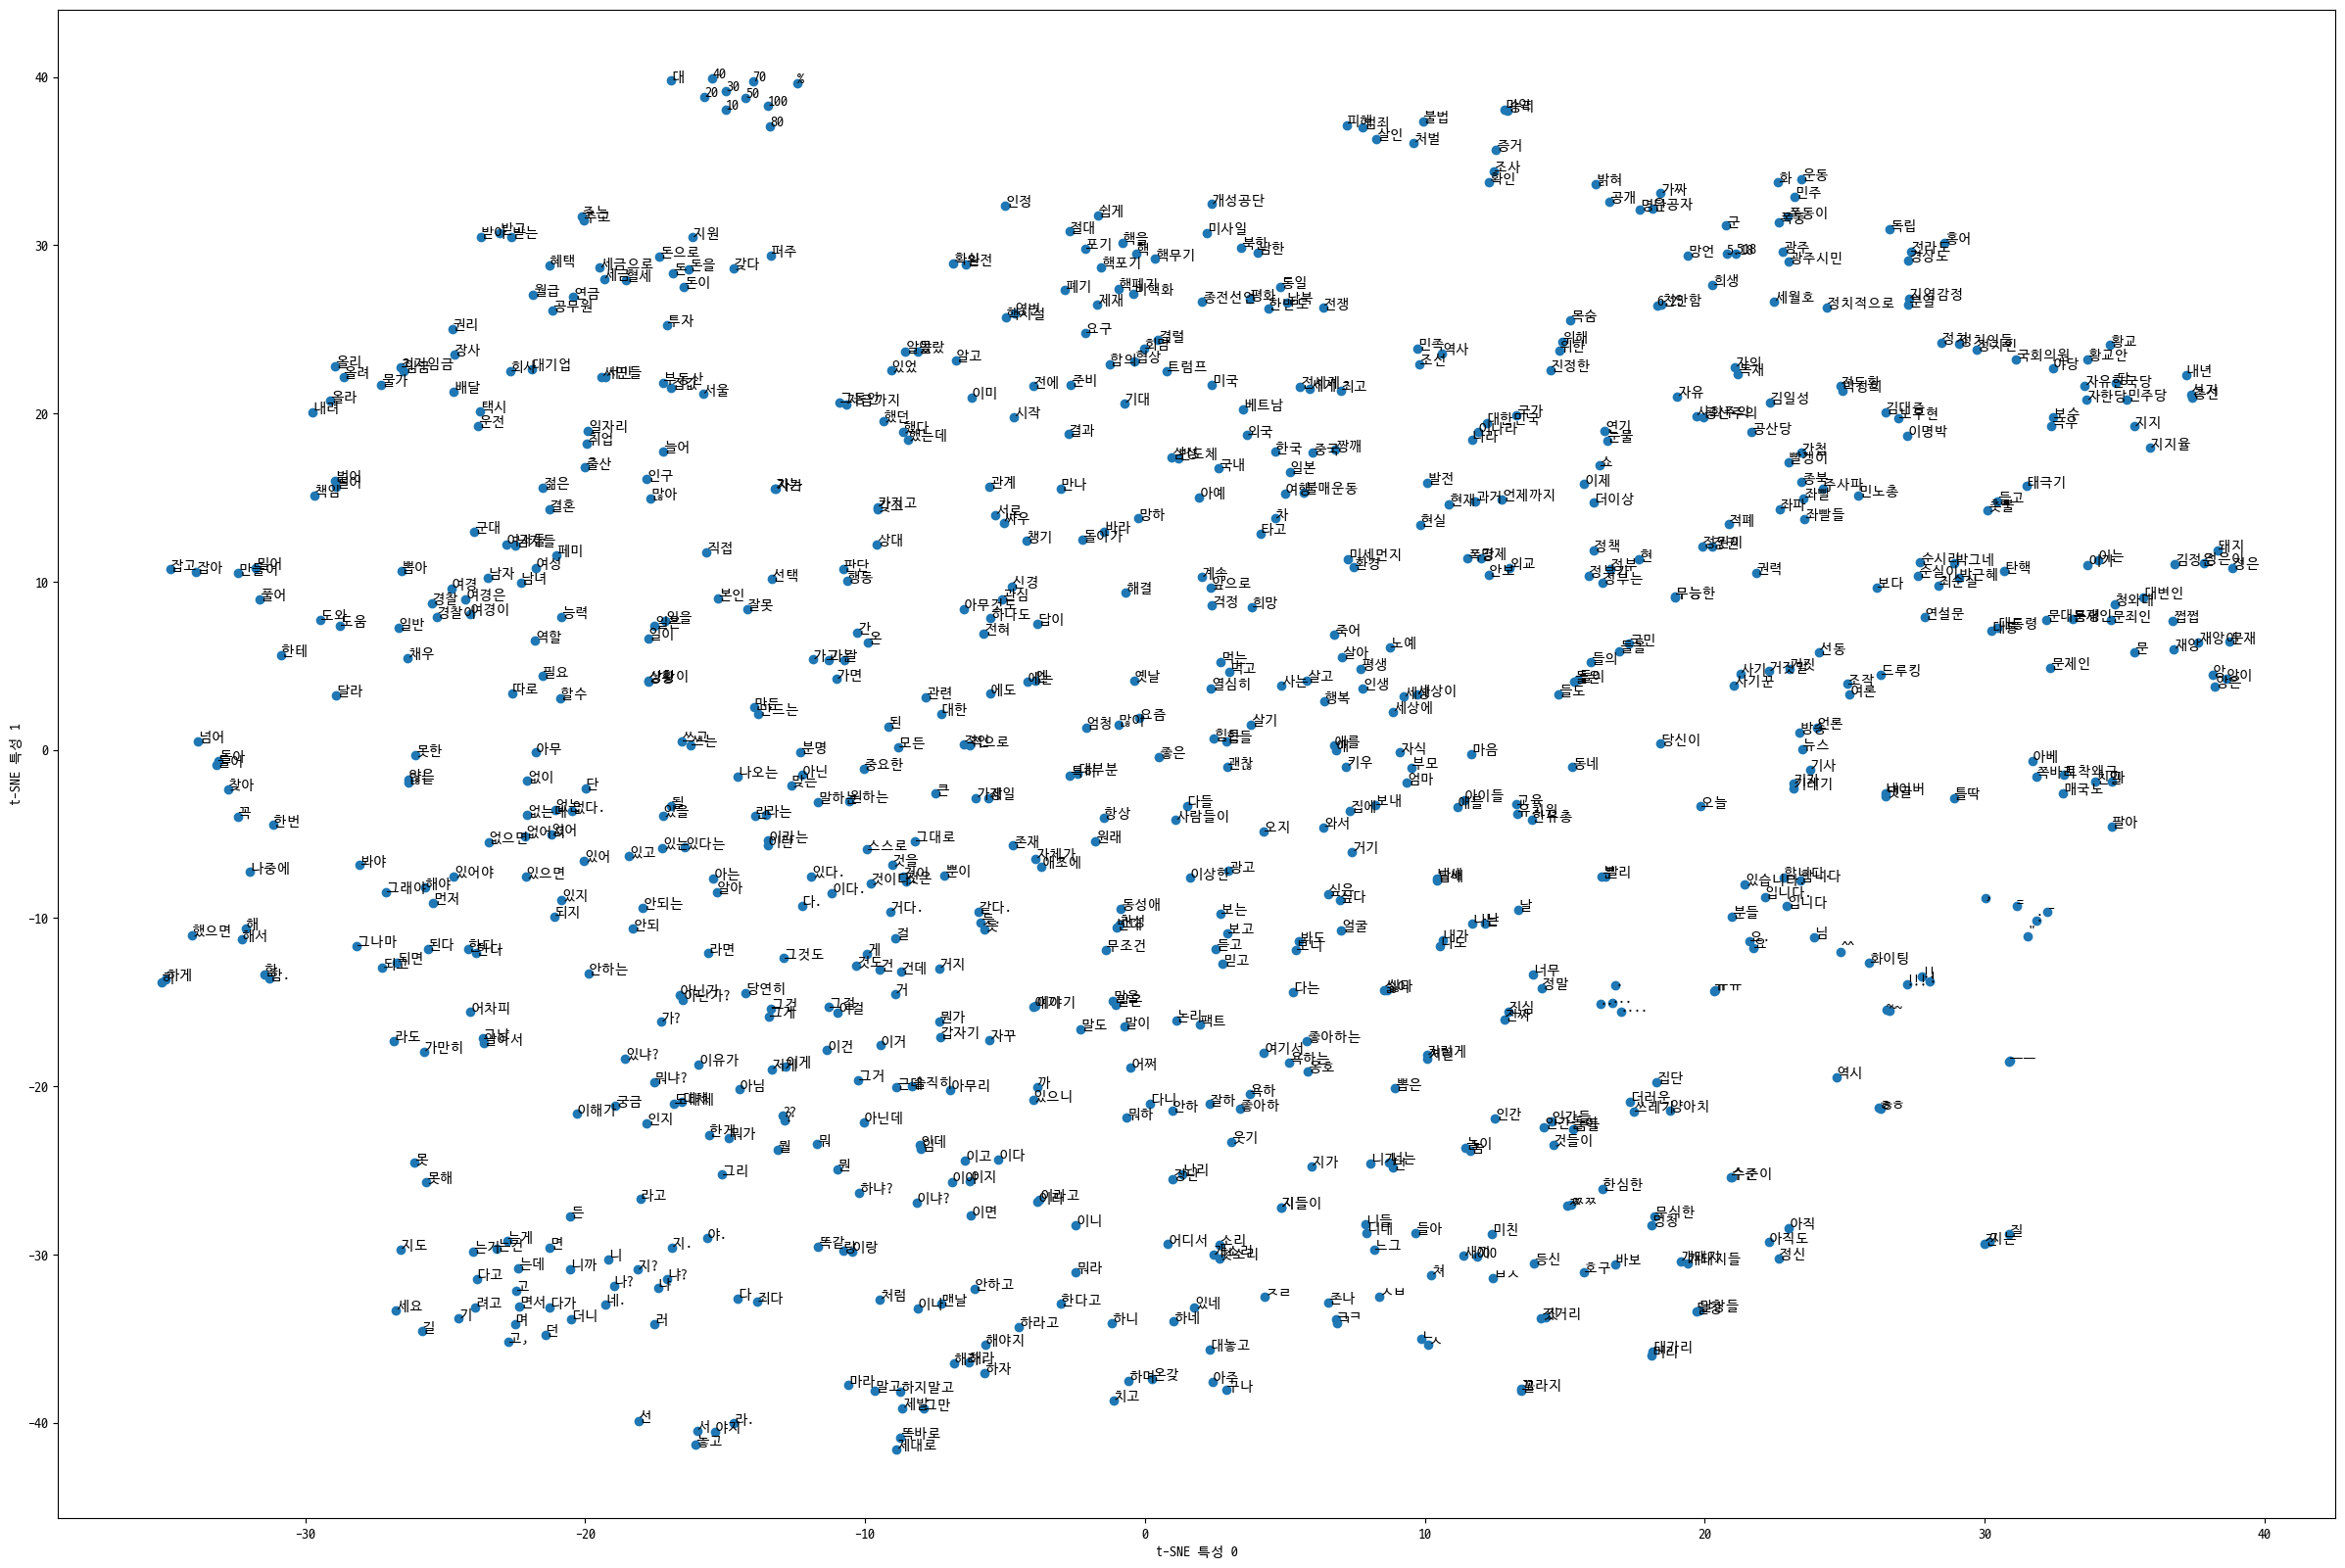

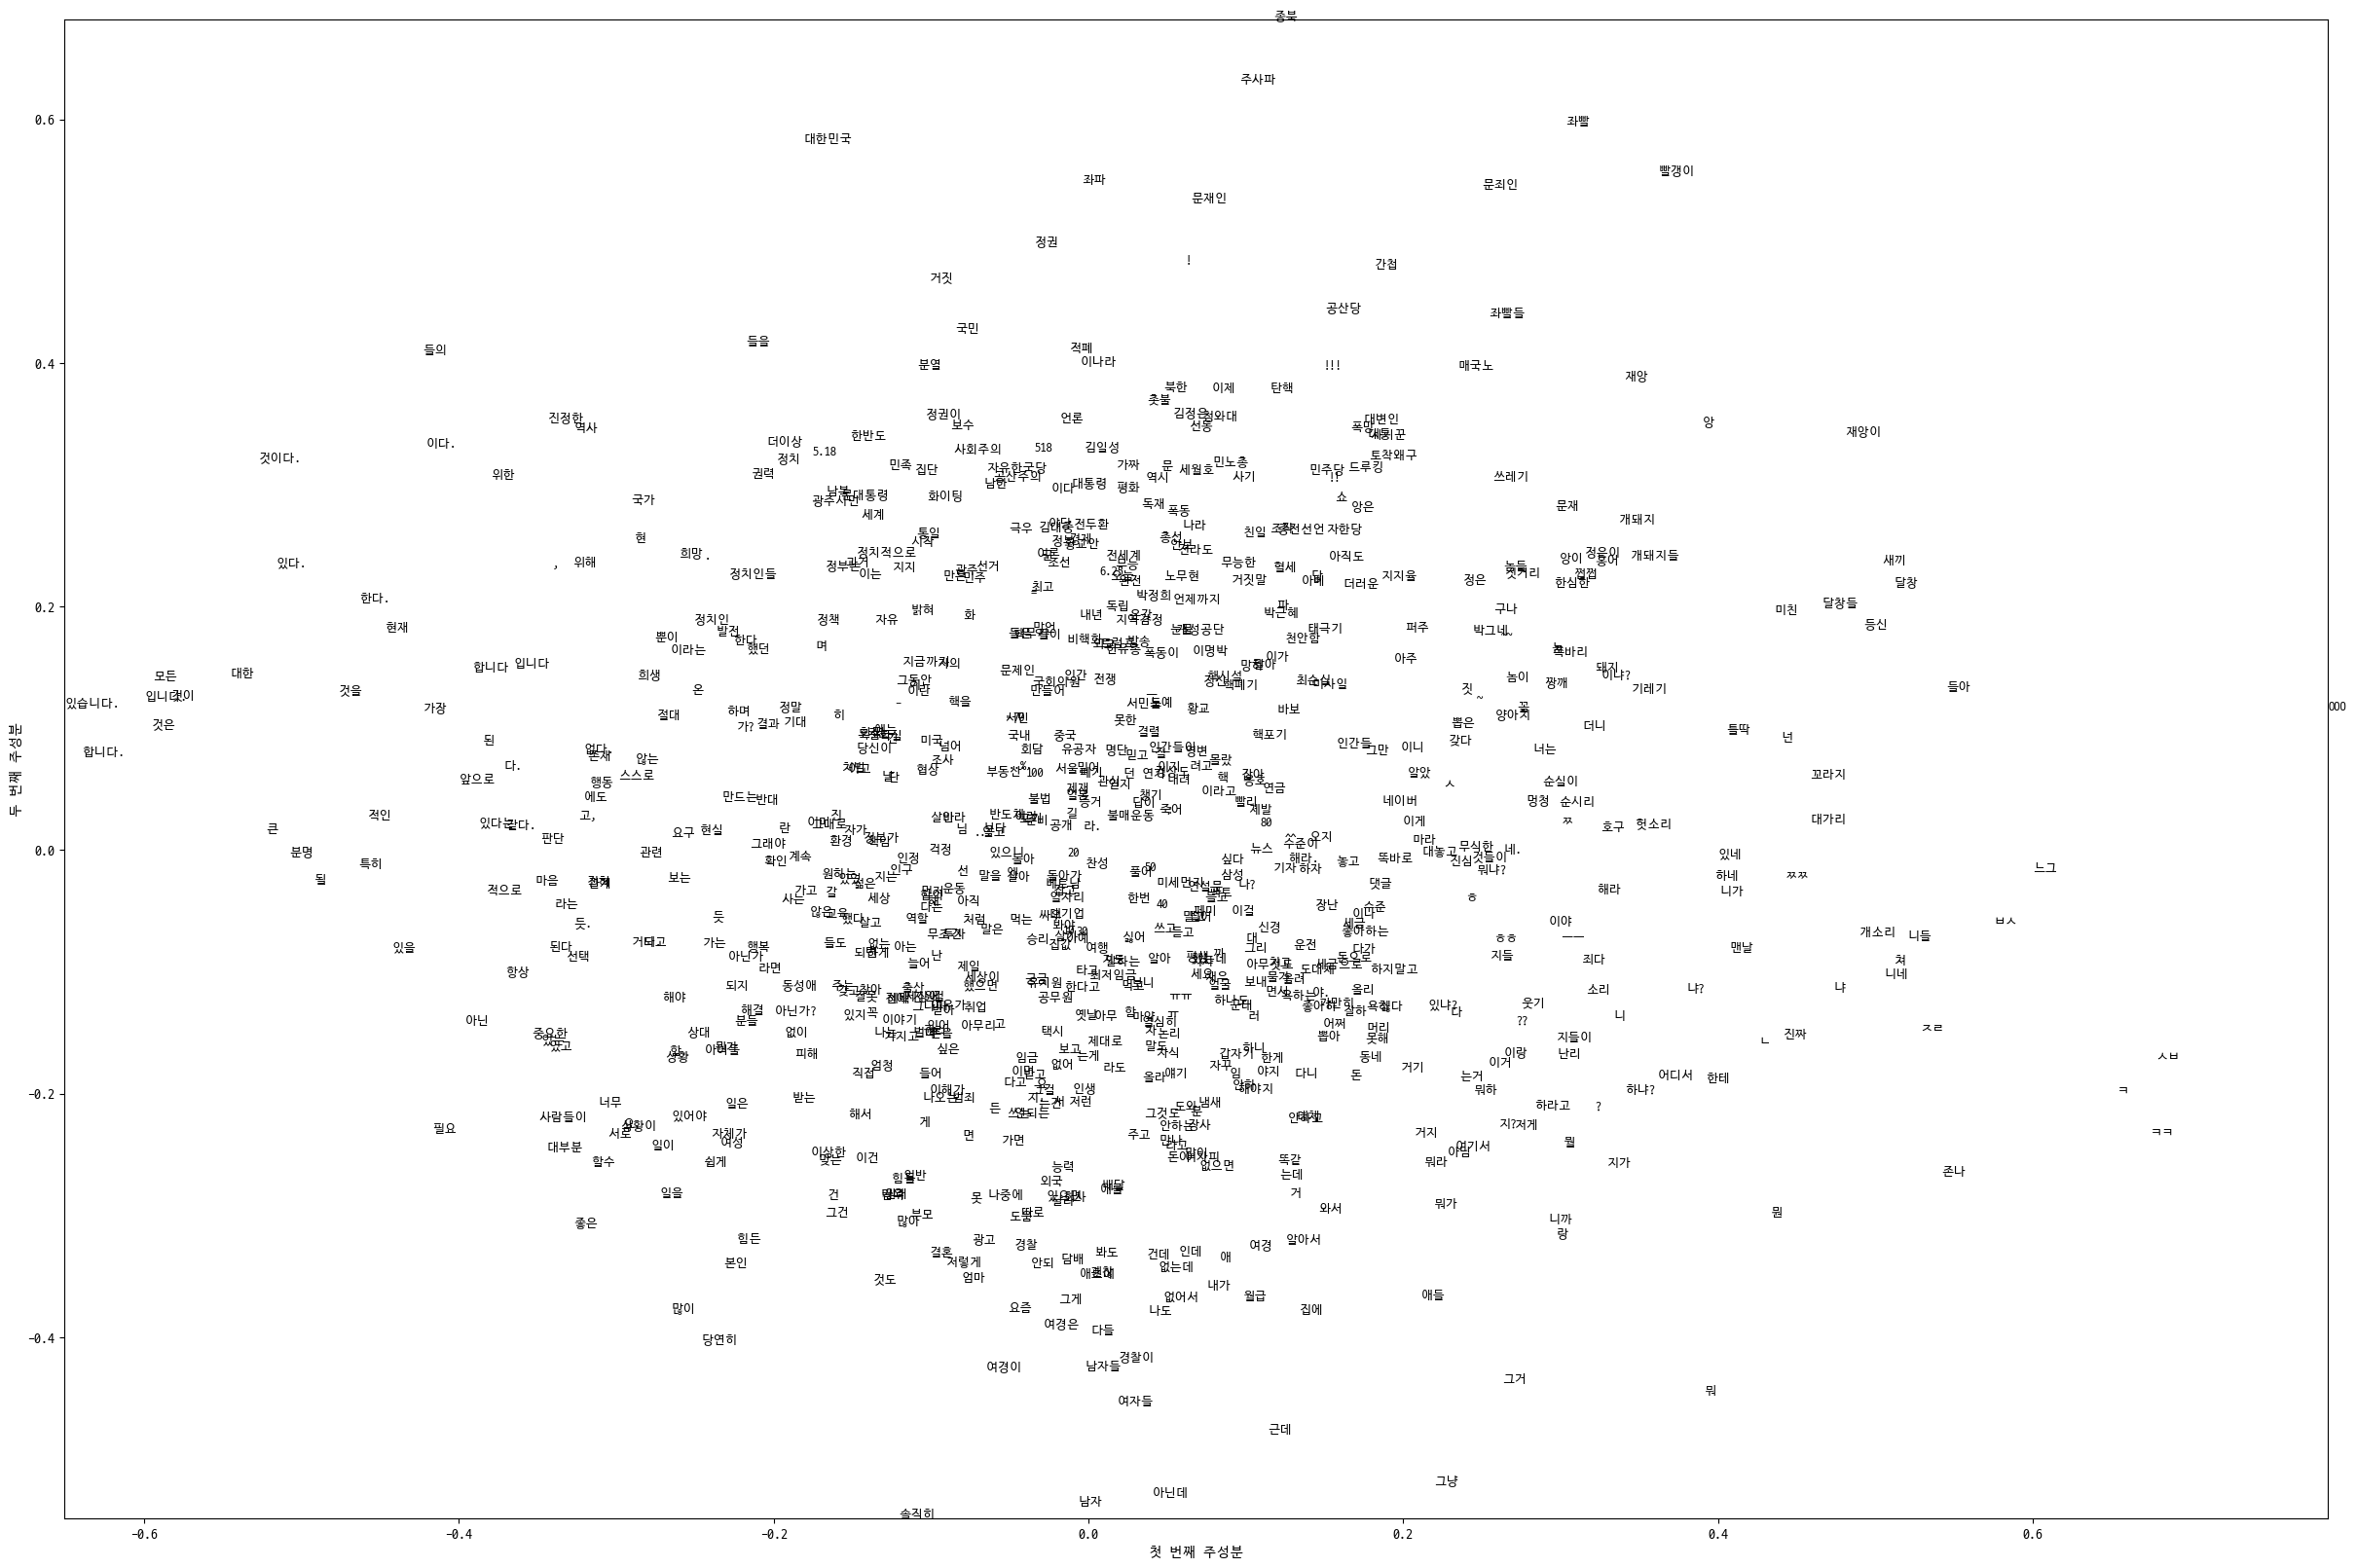

In [51]:
visualise('./model/cbow.model')

INFO - 14:46:24: loading projection weights from ./model/skipgram.model
INFO - 14:46:25: KeyedVectors lifecycle event {'msg': 'loaded (30996, 100) matrix of type float32 from ./model/skipgram.model', 'binary': False, 'encoding': 'utf8', 'datetime': '2024-02-11T14:46:25.748866', 'gensim': '4.3.2', 'python': '3.10.13 (main, Aug 24 2023, 12:59:26) [Clang 15.0.0 (clang-1500.1.0.2.5)]', 'platform': 'macOS-14.3.1-arm64-arm-64bit', 'event': 'load_word2vec_format'}


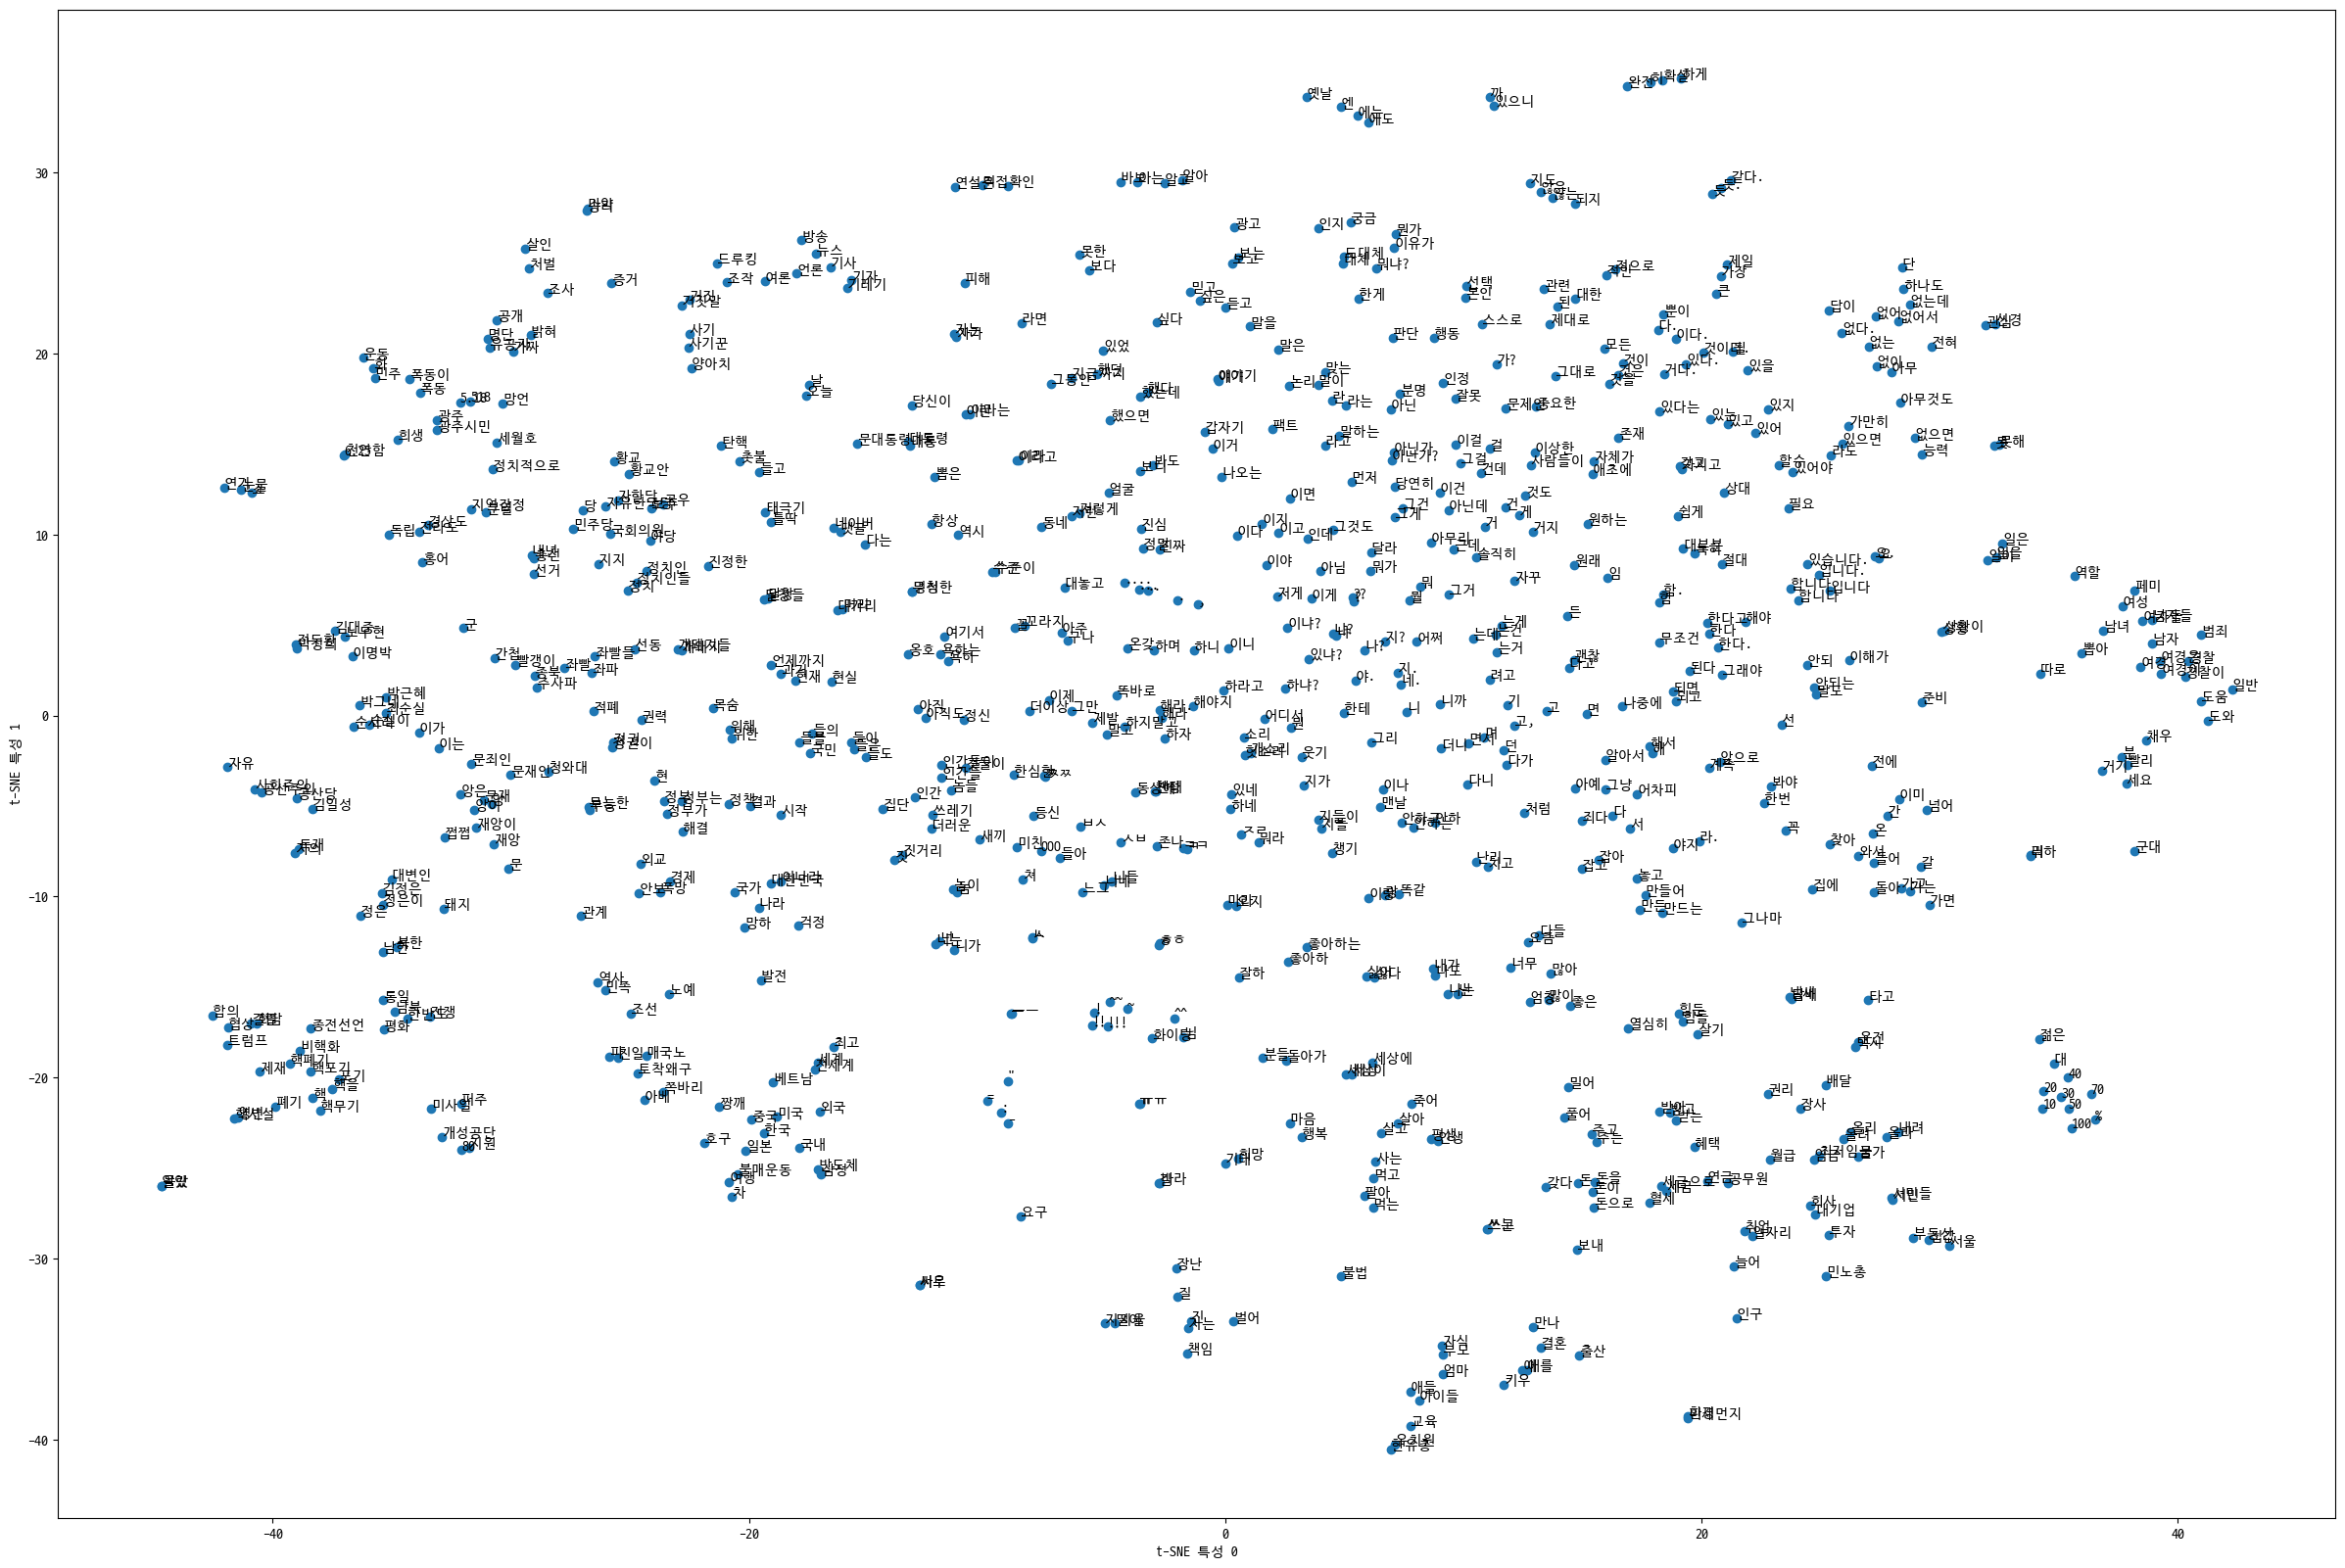

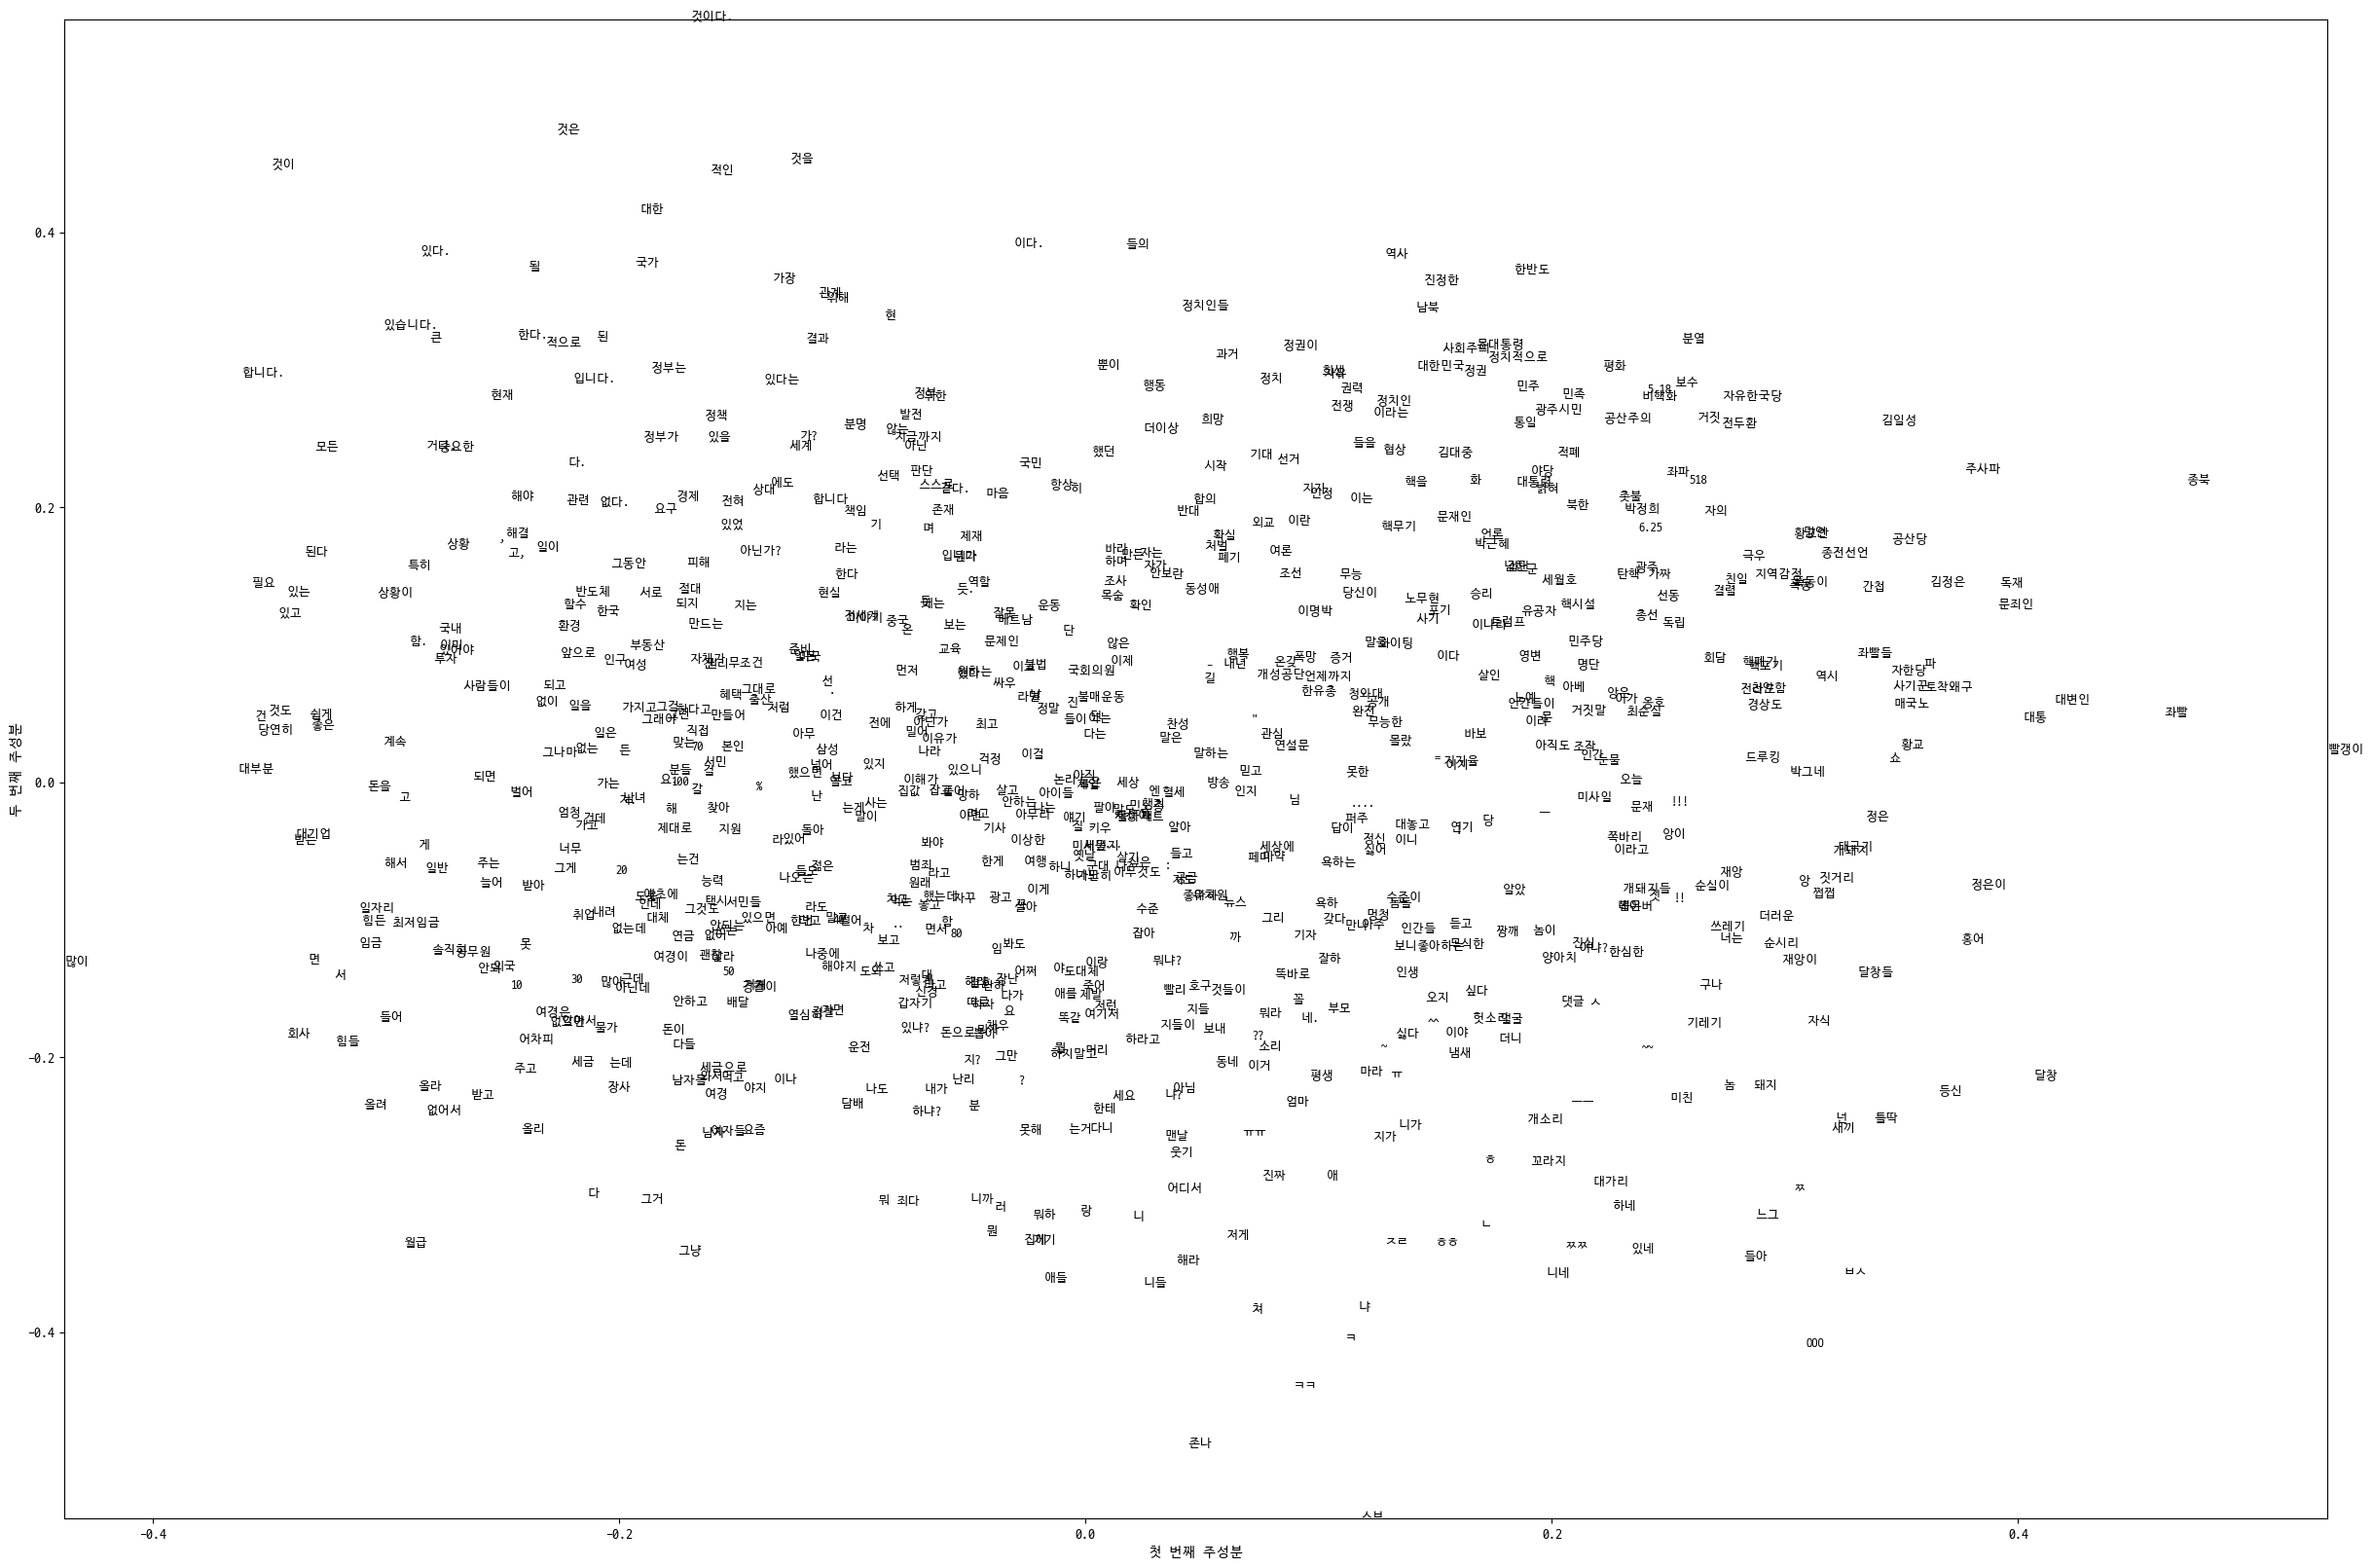

In [41]:
visualise('./model/skipgram.model')